In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import copy
from tqdm import tqdm

import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torchvision
from torchvision import transforms

# 防止内核挂掉
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
from torchvision.transforms import functional as F_vision

d:\Anaconda\envs\GPU_Pytorchpy39\lib\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


# Angular Spectrum Propagation (phase & amplitude)

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using Device: ',device)

Using Device:  cuda


### ***Loading and Viewing Dataset***

batch_number [100/300]
classes of the first batch: [0 1 2 3 4 5 6 7 8 9], number of classes: 10


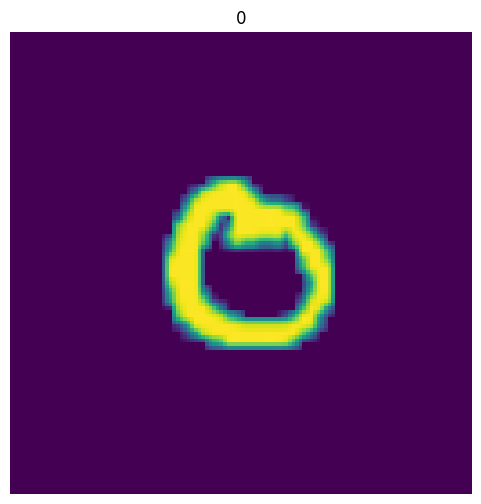

batch_number [200/300]
classes of the first batch: [0 1 2 3 4 5 6 7 8 9], number of classes: 10


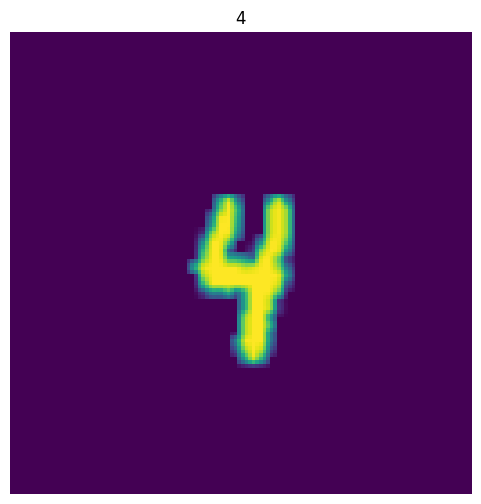

batch_number [300/300]
classes of the first batch: [0 1 2 3 4 5 6 7 8 9], number of classes: 10


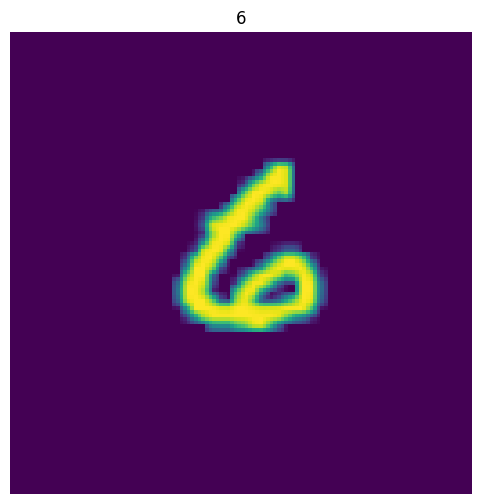

In [3]:
BATCH_SIZE = 200
IMG_SIZE = 64
N_pixels = 128
PADDING = (N_pixels - IMG_SIZE) // 2  # 避免边缘信息丢失

# 数据预处理并加载
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Resize((IMG_SIZE, IMG_SIZE)),
                                transforms.Pad([PADDING, PADDING], fill=(0), padding_mode='constant'),
                                # transforms.RandomAffine(degrees=(-5,5), translate=(0, 0.05),scale=(0.995,1.005)),
#                                 transforms.Normalize((0.1307,), (0.3081,))
                               ]
                               )
train_dataset = torchvision.datasets.MNIST("./data", train=True, transform=transform, download=True)
val_dataset = torchvision.datasets.MNIST("./data", train=False, transform=transform, download=True)
train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# 定义一个绘图函数
def image_plot(image, label):
#     cmap='RdBu'
    fig, ax = plt.subplots()
    ax.imshow(np.round(image.cpu().numpy(), 5)) # 显示图片每个像素点的振幅
    ax.axis('off')
    ax.set_title(label.cpu().numpy())
#     fig.colorbar(plt.cm.ScalarMappable(cmap=cmap))
    plt.show()

plt.rcParams["figure.figsize"] = (20, 6)
for i, (images, labels) in enumerate(train_dataloader):
    images = images.to(device)
#     images_E = torch.sqrt((torch.squeeze(images)+1)/2)
    images_E = torch.sqrt(torch.squeeze(images))
    labels = labels.to(device)

    '''
        每一个周期，共300个批次（i=0~299），一共60000个数据；
        train_dataloader包含300个批次，包括整个训练集；
        每一批次一共200张图片，对应200个标签, len(images[0])=1；
        images包含一个批次的200张图片（image[0].shape=torch.Size([1,28,28])），labels包含一个批次的200个标签，标签范围为0~9
    '''

    #每100个批次绘制第一张图片（含shuffle导致每次运行结果不一样）
    if (i + 1) % 100 == 0:
        classes = torch.unique(labels).cpu().numpy()
        classes_num = len(classes)
        print('batch_number [{}/{}]'.format(i + 1, len(train_dataloader)))
        print('classes of the first batch: {}, number of classes: {}'.format(classes, classes_num))#  第一个batch的总类
#         image_plot(images_phase[0], labels[0])
        image_plot(images_E[0], labels[0])


In [4]:
images_E.shape

torch.Size([200, 128, 128])

### ***Diffractive Layer***

In [5]:
class Diffractive_Layer(torch.nn.Module):
    # 模型初始化（构造实例），默认实参波长为532e-9，网格总数50，网格大小2e-6，z方向传播0.002。
    def __init__(self, λ = 532e-9, N_pixels = 128, pixel_size = 2e-6, distance = torch.tensor([0.005])):
        super(Diffractive_Layer, self).__init__() # 初始化父类
        
        # 以1/d为单位频率，得到一系列频率分量[0, 1, 2, ···, N_pixels/2-1,-N_pixels/2, ···, -1]/(N_pixels*d)。
        fx = np.fft.fftshift(np.fft.fftfreq(N_pixels, d = pixel_size))
        fy = np.fft.fftshift(np.fft.fftfreq(N_pixels, d = pixel_size))
        fxx, fyy = np.meshgrid(fx, fy) # 拉网格，每个网格坐标点为空间频率各分量。

        argument = (2 * np.pi)**2 * ((1. / λ) ** 2 - fxx ** 2 - fyy ** 2)

        # 计算传播场或倏逝场的模式kz，传播场kz为实数，倏逝场kz为复数
        tmp = np.sqrt(np.abs(argument))
        self.distance = distance.to(device)
        self.kz = torch.tensor(np.where(argument >= 0, tmp, 1j*tmp)).to(device)

    def forward(self, E):
        # 定义单个衍射层内的前向传播
        fft_c = torch.fft.fft2(E) # 对电场E进行二维傅里叶变换
        c = torch.fft.fftshift(fft_c).to(device) # 将零频移至张量中心
        phase = torch.exp(1j * self.kz * self.distance).to(device)
        angular_spectrum = torch.fft.ifft2(torch.fft.ifftshift(c * phase)) # 卷积后逆变换得到响应的角谱
        return angular_spectrum

### ***Propagation Layer***

In [6]:
class Propagation_Layer(torch.nn.Module):
    # 与上面衍射层大致相同，区别在于传输层是最后一个衍射层到探测器层间的部分，中间可以自定义加额外的器件。
    def __init__(self, λ = 532e-9, N_pixels = 128, pixel_size = 2e-6, distance = torch.tensor([0.001])):
        super(Propagation_Layer, self).__init__() # 初始化父类
        
        # 以1/d为单位频率，得到一系列频率分量[0, 1, 2, ···, N_pixels/2-1,-N_pixels/2, ···, -1]/(N_pixels*d)。
        fx = np.fft.fftshift(np.fft.fftfreq(N_pixels, d = pixel_size))
        fy = np.fft.fftshift(np.fft.fftfreq(N_pixels, d = pixel_size))
        fxx, fyy = np.meshgrid(fx, fy) # 拉网格，每个网格坐标点为空间频率各分量。

        argument = (2 * np.pi)**2 * ((1. / λ) ** 2 - fxx ** 2 - fyy ** 2)

        # 计算传播场或倏逝场的模式kz，传播场kz为实数，倏逝场kz为复数
        tmp = np.sqrt(np.abs(argument))
        self.distance = distance.to(device)
        self.kz = torch.tensor(np.where(argument >= 0, tmp, 1j*tmp)).to(device)

    def forward(self, E):
        # 定义单个衍射层内的前向传播
        fft_c = torch.fft.fft2(E) # 对电场E进行二维傅里叶变换
        c = torch.fft.fftshift(fft_c) # 将零频移至张量中心
        phase = torch.exp(1j * self.kz * self.distance).to(device)
        angular_spectrum = torch.fft.ifft2(torch.fft.ifftshift(c * phase)) # 卷积后逆变换得到响应的角谱
        return angular_spectrum

In [7]:
def propagation_along_z(initial_field, wl, N_pixels, pixel_size, z_step, number_of_z_steps):
    diffraction_step = Diffractive_Layer(distance = torch.tensor(z_step), λ = wl, N_pixels = N_pixels, pixel_size = pixel_size)
    z_ind = np.arange(0, number_of_z_steps)
    full_cross_section =  torch.zeros((len(z_ind),N_pixels, N_pixels),dtype = torch.complex64)
    full_cross_section[0] = torch.tensor(initial_field)
    with torch.no_grad():
        for ind in z_ind[1:]:
            full_cross_section[ind] = diffraction_step(full_cross_section[ind-1])
        return full_cross_section

DISCRETIZATION_STEP = 2.0e-6 # 网格大小
N_pixels = 128 # xy平面边长的元素点数量
z_step = 1e-5 # z方向步长
number_of_z_steps = 500 # z方向步数
z = np.arange(0, number_of_z_steps)*z_step # z坐标
wl = 532e-9 # 波长
coord_limit = (N_pixels//2)*DISCRETIZATION_STEP # 建立xy坐标系
# 拉网格
mesh = np.arange(-coord_limit, coord_limit, DISCRETIZATION_STEP)
x, y = np.meshgrid(mesh, mesh)

C:\Users\tengj\AppData\Local\Temp\ipykernel_30876\2310092833.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  full_cross_section[0] = torch.tensor(initial_field)


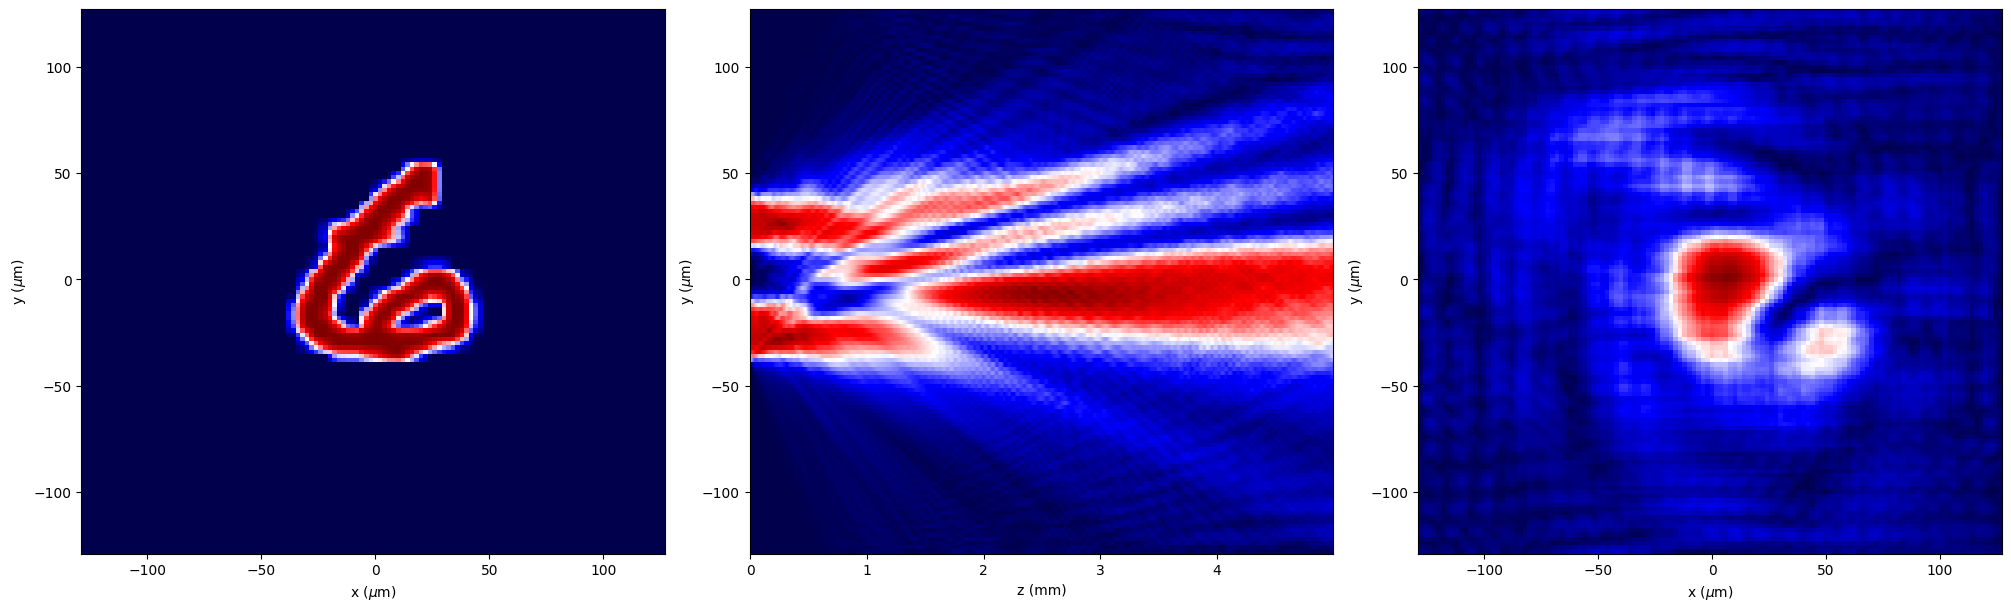

In [8]:
images_input = torch.flip(images_E[0], [0])
field = propagation_along_z(images_input, wl, N_pixels, DISCRETIZATION_STEP, z_step, number_of_z_steps)

plt.rcParams["figure.figsize"] = (20, 6)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, constrained_layout=True)
cmap = 'seismic'

# input
XY_field_in = np.abs(field[0].data.numpy())
ax1.pcolormesh(mesh*10**6, mesh*10**6, XY_field_in, cmap=cmap)
ax1.set_xlabel('x ($\mu$m)')
ax1.set_ylabel('y ($\mu$m)')

# yz cross-section
YZ_field = torch.abs(field[:, :, N_pixels//2])
ax2.pcolormesh(z*10**3, mesh*10**6, YZ_field.T, cmap=cmap)
ax2.set_xlabel('z (mm)')
ax2.set_ylabel('y ($\mu$m)')

# output
XY_field_out = torch.abs(field[-1]).T
ax3.pcolormesh(mesh*10**6, mesh*10**6, XY_field_out.T, cmap=cmap)
ax3.set_xlabel('x ($\mu$m)')
ax3.set_ylabel('y ($\mu$m)')

plt.show()

In [9]:
class Lens_Layer(torch.nn.Module):
    # 模型初始化（构造实例），默认实参波长为532e-9，网格总数50，网格大小20e-6，z方向传播0.002。
    def __init__(self, f = 5e-3, wl = 532e-9, N_pixels = 128, pixel_size = 2e-6, distance = torch.tensor([0.005])):
        super(Lens_Layer, self).__init__() # 初始化父类
        # 网格大小
        coord_limit = (N_pixels//2)*pixel_size # 建立xy坐标系
        # 拉网格
        mesh = np.arange(-coord_limit, coord_limit, pixel_size)
        x, y = np.meshgrid(mesh, mesh)
        self.phase_lens = torch.tensor(np.exp(-1j*np.pi/(wl*f) * (x**2 + y**2))).to(device)
        
        # 以1/d为单位频率，得到一系列频率分量[0, 1, 2, ···, N_pixels/2-1,-N_pixels/2, ···, -1]/(N_pixels*d)。
        fx = np.fft.fftshift(np.fft.fftfreq(N_pixels, d = pixel_size))
        fy = np.fft.fftshift(np.fft.fftfreq(N_pixels, d = pixel_size))
        fxx, fyy = np.meshgrid(fx, fy) # 拉网格，每个网格坐标点为空间频率各分量。

        argument = (2 * np.pi)**2 * ((1. / wl) ** 2 - fxx ** 2 - fyy ** 2)

        # 计算传播场或倏逝场的模式kz，传播场kz为实数，倏逝场kz为复数
        tmp = np.sqrt(np.abs(argument))
        self.distance = distance.to(device)
        self.kz = torch.tensor(np.where(argument >= 0, tmp, 1j*tmp)).to(device)

    def forward(self, E):
        # 定义单个衍射层内的前向传播
        fft_c = torch.fft.fft2(E) # 对电场E进行二维傅里叶变换
        c = torch.fft.fftshift(fft_c).to(device) # 将零频移至张量中心
        phase = torch.exp(1j * self.kz * self.distance).to(device)
        angular_spectrum = torch.fft.ifft2(torch.fft.ifftshift(c * phase)) # 卷积后逆变换得到响应的角谱
        return angular_spectrum*self.phase_lens

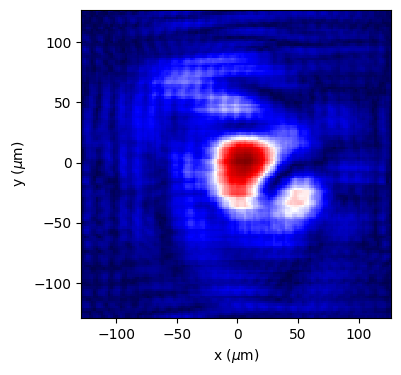

In [10]:
# 不看中间的光束传输过程，可以根据角谱直接计算出z位置的光场分布，结果与考虑传输过程相同
images_input = torch.flip(images_E[0], [0])
field_test = Lens_Layer(distance=torch.tensor(5e-3))(images_input)

# output
plt.rcParams["figure.figsize"] = (4, 4)
fig, ax = plt.subplots(1)
XY_field_out = torch.abs(field_test).T.cpu().numpy()
ax.pcolormesh(mesh*10**6, mesh*10**6, XY_field_out.T, cmap=cmap)
ax.set_xlabel('x ($\mu$m)')
ax.set_ylabel('y ($\mu$m)')

plt.show()

In [11]:
# 在傅里叶平面上设置一个正方形光阑，光阑矩阵
square_aper = torch.zeros((N_pixels,N_pixels), dtype = torch.double)
L_side = int(N_pixels*1) # 1：全透，1/2中央二分之一区域透光
x1 = int((N_pixels-L_side)/2)
x2 = int((N_pixels+L_side)/2)
square_aper[x1:x2, x1:x2] = 1 # 设置探测器区域

f = 5e-3
field_lens1 = field[-1]*np.exp(-1j*np.pi/(wl*f) * (x**2 + y**2))
field_out_lens1_F1 = propagation_along_z(field_lens1, wl, N_pixels, DISCRETIZATION_STEP, z_step, number_of_z_steps)
field_out_lens1_F1[-1] = field_out_lens1_F1[-1] * square_aper
field_out_lens1_F2 = propagation_along_z(field_out_lens1_F1[-1], wl, N_pixels, DISCRETIZATION_STEP, z_step, number_of_z_steps)
field_lens2 = field_out_lens1_F2[-1]*np.exp(-1j*np.pi/(wl*f) * (x**2 + y**2))
field_out_lens2 = propagation_along_z(field_lens2, wl, N_pixels, DISCRETIZATION_STEP, z_step, number_of_z_steps)

YZ_field_lens1_F1 = torch.abs(field_out_lens1_F1[:, N_pixels//2])
YZ_field_lens1_F2 = torch.abs(field_out_lens1_F2[:, N_pixels//2])
YZ_field_lens2 = torch.abs(field_out_lens2[:, N_pixels//2])
YZ_field_total = torch.cat((YZ_field, YZ_field_lens1_F1, YZ_field_lens1_F2, YZ_field_lens2), dim = 0)
z_total = np.arange(0, 4*number_of_z_steps)*z_step # z坐标

C:\Users\tengj\AppData\Local\Temp\ipykernel_30876\2310092833.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  full_cross_section[0] = torch.tensor(initial_field)


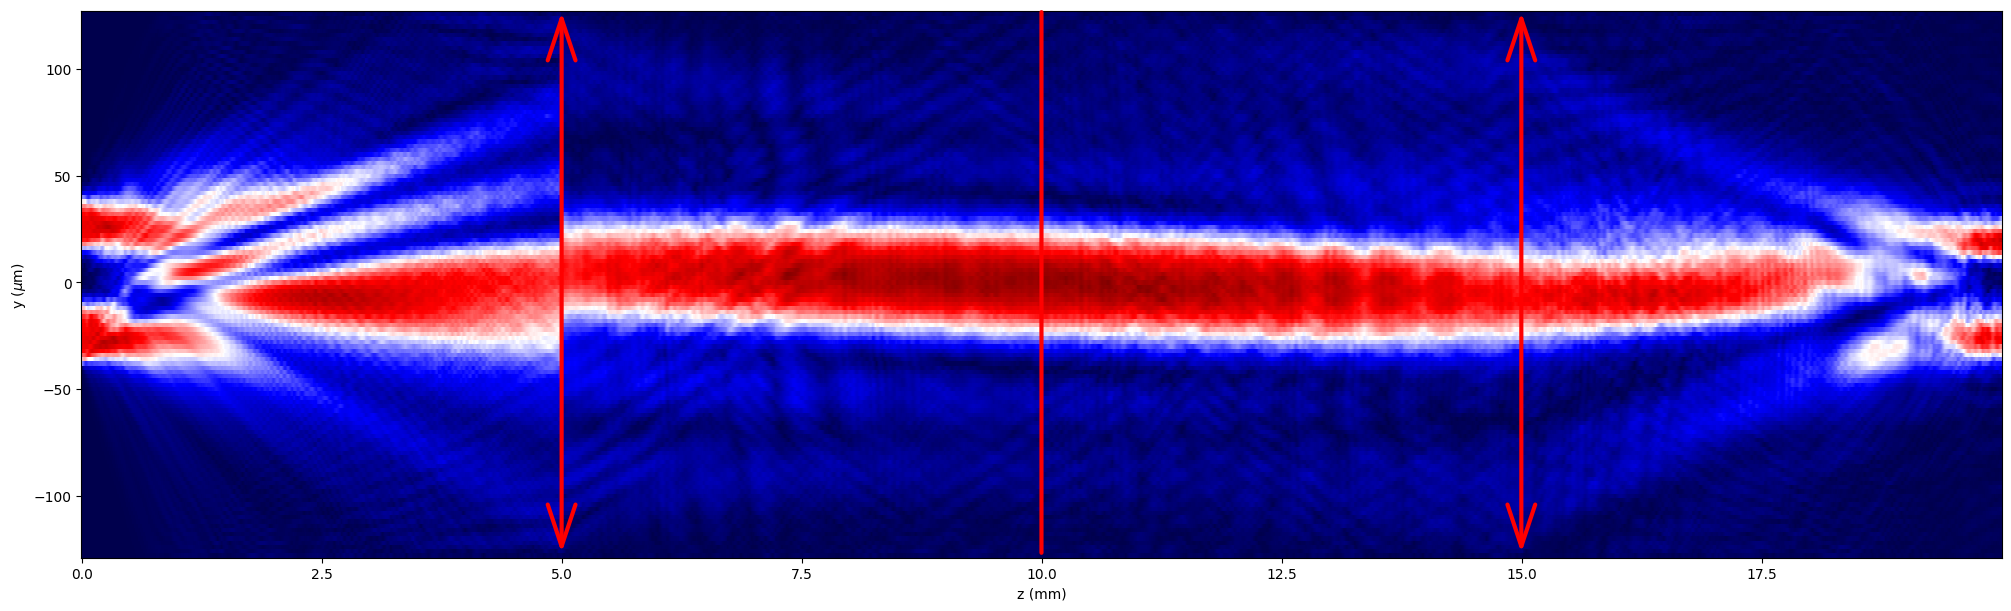

In [12]:
plt.rcParams["figure.figsize"] = (20, 6)
# yx cross-section
fig, ax = plt.subplots(1, constrained_layout=True)
ax.pcolormesh(z_total*10**3, mesh*10**6, YZ_field_total.T, cmap = 'seismic')
ax.set_xlabel('z (mm)')
ax.set_ylabel('y ($\mu$m)')

plt.annotate('', xy=(max(z_total*10**3)/4, -coord_limit*10**6), xytext=(max(z_total*10**3)/4, coord_limit*10**6), 
             arrowprops=dict(arrowstyle='<->, head_length=3, head_width=1', lw=3, color='red'))

plt.annotate('', xy=(max(z_total*10**3)/2, -coord_limit*10**6), xytext=(max(z_total*10**3)/2, coord_limit*10**6), 
             arrowprops=dict(arrowstyle='-', lw=3, color='red'))

plt.annotate('', xy=(max(z_total*10**3)*3/4, -coord_limit*10**6), xytext=(max(z_total*10**3)*3/4, coord_limit*10**6), 
             arrowprops=dict(arrowstyle='<->, head_length=3, head_width=1', lw=3, color='red'))

plt.show()

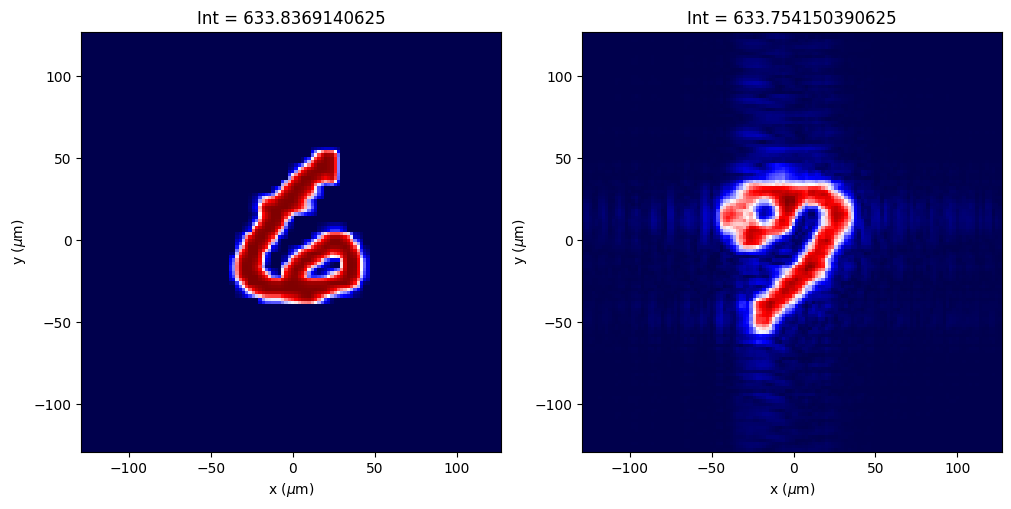

In [13]:
plt.rcParams["figure.figsize"] = (10, 10)
fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True)
# input
XY_field_in = np.abs(field[0].data.numpy())
ax1.pcolormesh(mesh*10**6, mesh*10**6, XY_field_in, cmap=cmap)
ax1.set_xlabel('x ($\mu$m)')
ax1.set_ylabel('y ($\mu$m)')
ax1.set_aspect('equal')
ax1.set_title('Int = {}'.format(torch.pow(abs(torch.tensor(XY_field_in)), 2).sum()))

# output
XY_field_out_lens2 = torch.abs(field_out_lens2[-1]).T
ax2.pcolormesh(mesh*10**6, mesh*10**6, XY_field_out_lens2.T, cmap=cmap)
ax2.set_xlabel('x ($\mu$m)')
ax2.set_ylabel('y ($\mu$m)')
ax2.set_aspect('equal')
ax2.set_title('Int = {}'.format(torch.pow(abs(XY_field_out_lens2), 2).sum()))

plt.axis('square')
plt.show()

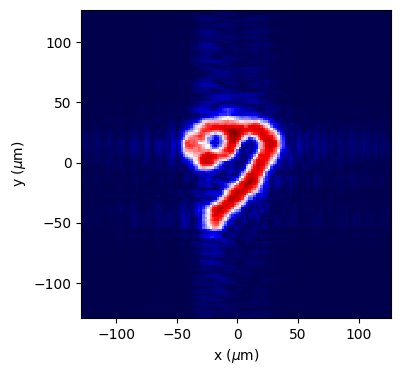

In [14]:
# 在傅里叶平面上设置一个正方形光阑，光阑矩阵
square_aper = torch.zeros((N_pixels,N_pixels), dtype = torch.double)
L_side = int(N_pixels*1) # 1：全透，1/2中央二分之一区域透光
x1 = int((N_pixels-L_side)/2)
x2 = int((N_pixels+L_side)/2)
square_aper[x1:x2, x1:x2] = 1 # 设置探测器区域

# 不看中间的光束传输过程，可以根据角谱直接计算出z位置的光场分布，结果与考虑传输过程相同
images_input = torch.flip(images_E[0], [0])
field_test1 = Lens_Layer(distance=torch.tensor(5e-3))(images_input) # 物面到第一个lens
field_test2 = Diffractive_Layer(distance=torch.tensor(5e-3))(field_test1) # 第一个lens到傅里叶平面
field_test3 = field_test2 * square_aper.to(device) # 经过傅里叶平面的光阑
field_test4 = Lens_Layer(distance=torch.tensor(5e-3))(field_test3) # 傅里叶平面到第二个lens
field_test5 = Propagation_Layer(distance=torch.tensor(5e-3))(field_test4) # 第二个lens到像面

# output
plt.rcParams["figure.figsize"] = (4, 4)
fig, ax = plt.subplots(1)
XY_field_out = torch.abs(field_test5).T.cpu().numpy()
ax.pcolormesh(mesh*10**6, mesh*10**6, XY_field_out.T, cmap=cmap)
ax.set_xlabel('x ($\mu$m)')
ax.set_ylabel('y ($\mu$m)')

plt.show()

### ***Detectors Layer***

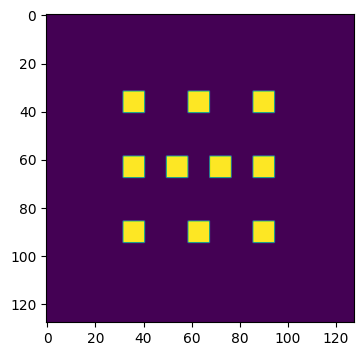

In [15]:
# 生成一行探测器。指定探测器个数N_det，在x方向上生成齐高等间距det_step的一组探测器
# left，right，up和down分别是该行矩形探测器的四个顶点坐标。
def generate_det_row(det_size, start_pos_x, start_pos_y, det_step, N_det):
    p = []
    for i in range(N_det):
        left = start_pos_x+i*(int(det_step)+det_size)
        right = left + det_size
        up = start_pos_y
        down = start_pos_y + det_size
        p.append((up, down, left, right))
    return p

# 生成三行探测器。利用generate_det_row函数生成三行等间距矩形探测器。
def set_det_pos(det_size = 20, start_pos_x = 46, start_pos_y = 46, 
                N_det_sets = [3, 4, 3], det_steps_x = [2, 1, 2], det_steps_y = 2):
    p = []
    for i in range(len(N_det_sets)):
        p.append(generate_det_row(det_size, start_pos_x, start_pos_y+i*(det_steps_y+1)
                                  *det_size, det_steps_x[i]*det_size, N_det_sets[i]))
    return list(itertools.chain.from_iterable(p))

# def set_det_pos(det_size=20, start_pos_x = 46, start_pos_y = 46):
#     p = []
#     p.append(generate_det_row(det_size, start_pos_x, start_pos_y, 2*det_size, 3))
#     p.append(generate_det_row(det_size, start_pos_x, start_pos_y+3*det_size, 1*det_size, 4))
#     p.append(generate_det_row(det_size, start_pos_x, start_pos_y+6*det_size, 2*det_size, 3))
#     return list(itertools.chain.from_iterable(p))

# 获取最终衍射光强在各个探测器上的分布情况
def detector_region(Int):
    detectors_list = []
    total = 0
    full_Int = Int.sum(dim=(1,2)) # 统计总光强
    for det_x0, det_x1, det_y0, det_y1 in detector_pos: # 计算各个探测器区间内的光强占比
        detectors_list.append((Int[:, det_x0 : det_x1, det_y0 : det_y1].sum(dim=(1, 2))/full_Int).unsqueeze(-1))
    for ele in range(0, len(detectors_list)):
        total = total + detectors_list[ele]
    return torch.cat(detectors_list, dim = 1)/total

# 指定生成的十个探测器的位置。
# detector_pos = [
#     (46, 66, 46, 66),
#     (46, 66, 106, 126),
#     (46, 66, 166, 186),
#     (106, 126, 46, 66),
#     (106, 126, 86, 106),
#     (106, 126, 126, 146),
#     (106, 126, 166, 186),
#     (166, 186, 46, 66),
#     (166, 186, 106, 126),
#     (166, 186, 166, 186)

# 定义探测器模型基本参数
det_size = 9
det_pad = (N_pixels - 7*det_size)//2
detector_pos = set_det_pos(det_size, det_pad, det_pad)

# 定义探测器层的图片张量
labels_image_tensors=torch.zeros((10,N_pixels,N_pixels), device = device, dtype = torch.double)
for ind, pos in enumerate(detector_pos):
    pos_l, pos_r, pos_u, pos_d = pos
    labels_image_tensors[ind, pos_l:pos_r, pos_u:pos_d] = 1 # 设置探测器区域
    labels_image_tensors[ind] = labels_image_tensors[ind]/labels_image_tensors[ind].sum() # 归一化探测器层
det_ideal = labels_image_tensors.cpu().numpy().sum(axis = 0)

plt.rcParams["figure.figsize"] = (4, 4)
plt.imshow(det_ideal) # 查看探测器层

### ***D2NN***

In [16]:
# 先做一个模型初始化，将生成的初始随机相位参数与模型分离，以便于后面对其他参数分别训练。
# 初始化每层相位板的相位参数（0到1区间均匀分布）,并将其注册为可学习的Parameter。
num_layers = 2
distance_between_layers = 0.004, 0.002, 0.004, 0.005
phase = [torch.nn.Parameter(torch.from_numpy(np.random.random(size=(N_pixels, N_pixels)).
                                                          astype('float32'))) for _ in range(num_layers)]
# Amp = [torch.nn.Parameter(torch.from_numpy(np.random.random(size=(N_pixels, N_pixels)).
#                                                           astype('float32'))) for _ in range(num_layers)]
# 初始化层间距，预训练时（先只训练相位）设置梯度requires_grad=False。
distance = [torch.nn.Parameter(distance_between_layers[i]*torch.tensor([1])) for i in range(num_layers+2)]

In [17]:
angle = 0
scale = 1.0
shift = 0

In [18]:
class DNN(torch.nn.Module):
    """""""""""""""""""""
    phase & amplitude modulation
    """""""""""""""""""""
    def __init__(self, phase = [], num_layers = 2, wl = 532e-9, N_pixels = 128, pixel_size = 20e-6, 
                 distance = []):

        super(DNN, self).__init__()
        
        # 初始化每层相位板的相位参数（0到1区间均匀分布）,并将其注册为可学习的Parameter。
#         self.phase = [torch.nn.Parameter(torch.from_numpy(np.random.random(size=(N_pixels, N_pixels)).
#                                                           astype('float32')-0.5)) for _ in range(num_layers)]
        # 向网络中添加每层相位板的参数
        for i in range(num_layers):
            self.register_parameter("phase" + "_" + str(i), phase[i])
        # 向网络中添加每层相位板的衰减参数
#         for i in range(num_layers):
#             self.register_parameter("Amp" + "_" + str(i), Amp[i])
        # 向网络中添加层间距的参数
        for i in range(num_layers+2):
            self.register_parameter("distance" + "_" + str(i), distance[i])
        
        # 定义透镜面
        self.lens_layer1 = Lens_Layer()
        
        # 定义中间的衍射层
        self.diffractive_layers = torch.nn.ModuleList([Diffractive_Layer(wl, N_pixels, pixel_size, distance[i])
                                                       for i in range(num_layers)])
        
        # 在相位板后加一层饱和吸收体，用ReLU模拟非线性
#         self.relu = torch.nn.ReLU()
        
        # 定义透镜面
        self.lens_layer2 = Lens_Layer(distance=distance[-2])
        
        # 定义最后的探测层
        self.last_diffractive_layer = Propagation_Layer(wl, N_pixels, pixel_size, distance[-1])
        self.sofmax = torch.nn.Softmax(dim=-1)
    
    # 计算多层衍射前向传播
    def forward(self, E):
        E = self.lens_layer1(E)
        for index, layer in enumerate(self.diffractive_layers):
            temp = layer(E)
            phase[index].data = (F_vision.affine(phase[index].data.unsqueeze(0), angle=angle, translate=(shift,shift), scale=scale, shear=0.0))[0]
            constr_phase = 2*np.pi*phase[index]
            # 这里相当于加了一层sigmoid非线性激活，将相位控制在0到2pi
#             constr_phase = 2*np.pi*torch.sigmoid(phase[index])
            exp_j_phase = torch.exp(1j*constr_phase) #torch.cos(constr_phase)+1j*torch.sin(constr_phase)
            E = temp * exp_j_phase
            E_phase = E/torch.abs(E)
            I = torch.abs(E)**2
            I_th = torch.mean(I, dim=(-2, -1), keepdim=True)/2
            I_th = (I_th * torch.ones_like(E)).to(dtype=torch.float64)
            I_out = torch.nn.ReLU()(I.to(dtype=torch.float64)-I_th)
            E = torch.sqrt(I_out)*E_phase
        E = self.lens_layer2(E)
        E = self.last_diffractive_layer(E)
        Int = torch.abs(E)**2
#         output = self.sofmax(detector_region(Int))
        output = detector_region(Int)
        return output, Int

In [19]:
model = DNN(phase = phase, distance = distance).to(device)
print(model)

DNN(
  (lens_layer1): Lens_Layer()
  (diffractive_layers): ModuleList(
    (0-1): 2 x Diffractive_Layer()
  )
  (lens_layer2): Lens_Layer()
  (last_diffractive_layer): Propagation_Layer()
  (sofmax): Softmax(dim=-1)
)


In [20]:
# 先只训练相位，层间距先设定0.005。之后再在0.005这个基础上微调训练层间距。
for param in model.parameters():
    param.requires_grad = False

for name, param in model.named_parameters():
    if name.find('phase') != -1:
        exec('model.' + name + '.requires_grad_(True)')
# for name, param in model.named_parameters():
#     if name.find('Amp') != -1:
#         exec('model.' + name + '.requires_grad_(True)')
    
print("Params to learn:")
params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 phase_0
	 phase_1


### ***Training***

In [21]:
# 定义训练函数
def train(model, loss_function, optimizer, trainloader, testloader, epochs = 10, device = 'cpu', filename = 'best.pt'):
    train_loss_hist = []
    test_loss_hist = []
    train_acc_hist = []
    test_acc_hist = []
    best_acc = 0
    best_model_wts = copy.deepcopy(model.state_dict())
    for epoch in range(epochs):
        ep_loss = 0
        # 每个epoch开始时启动Batch_Normalization和Dropout。BN层能够用到每一批数据的均值和方差，Dropout随机取一部分网络连接来训练更新参数。
        model.train()
        correct = 0
        total = 0
        # 加载进度条
        for images, labels in tqdm(trainloader):
            
            images = torch.sqrt(images.to(device).squeeze())
#             images = torch.sqrt(F.pad(torch.squeeze(images), pad=(PADDING, PADDING, PADDING, PADDING)))
            labels = labels.to(device)
            det_labels = F.one_hot(labels, num_classes=10).to(dtype=torch.float64)
#             det_labels = labels_image_tensors[labels] # 定义各标签的探测器层张量
            
            optimizer.zero_grad() # 梯度清零
            out_label, out_img = model(images) # 得到预测各个探测器上的光强分布以及探测层光强分布
            
            _, predicted = torch.max(out_label, 1) # 找到光强分布占比最大的探测器，并作为预测结果
            correct += (predicted == labels).sum().item() # 得到一个batch的预测结果。如果预测值等于标签值，则正确值加一。
            total += labels.size(0) # 得到一个batch的标签总数

            full_int_img = out_img.sum(axis=(1,2))
#             loss = loss_function(out_img/full_int_img[:,None,None], det_labels) # 光强分布归一化后送入损失函数（与完美探测结果进行比较）
#             loss = loss_function(out_label, det_labels)
            loss = loss_function(out_label, det_labels*0.1)
            
            loss.backward() # 反向传播
            optimizer.step() # 参数更新
            ep_loss += loss.item() # 更新本次epoch的损失
        train_loss_hist.append(ep_loss /len(trainloader)) # 计算平均损失
        train_acc_hist.append(correct /total) # 计算准确率
        #train_acc_hist.append(validate(model, trainloader,device))

        #test_acc_hist.append(validate(model, testloader,device))
        # if test_acc_hist[-1][0]>best_acc:
        #     best_model=copy.deepcopy(model)
        
        ep_loss = 0
        # 不启用Batch Normalization和Dropout。测试过程中要保证BN层的均值和方差不变，且利用到了所有网络连接，即不进行随机舍弃神经元。
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad(): # 停止梯度更新
            for images, labels in tqdm(testloader):
                images = images.to(device).squeeze()
#                 images = torch.sqrt(F.pad(torch.squeeze(images), pad=(PADDING, PADDING, PADDING, PADDING)))
                labels = labels.to(device)
                det_labels = F.one_hot(labels, num_classes=10).to(dtype=torch.float64)
#                 det_labels = labels_image_tensors[labels]

                out_label, out_img = model(images)
                _, predicted = torch.max(out_label, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

                full_int_img = out_img.sum(axis=(1,2))
#                 loss = loss_function(out_img/full_int_img[:,None,None], det_labels)
#                 loss = loss_function(out_label, det_labels)
                loss = loss_function(out_label, det_labels*0.1)
                
                #直接计算损失，无反向传播和梯度更新。
                ep_loss += loss.item()
        test_loss_hist.append(ep_loss / len(testloader))
        test_acc_hist.append(correct / total)
        # 如果最后一次训练的准确率大于之前最好的准确率，则将最后一次的模型保存为最佳模型。
        if test_acc_hist[-1]>best_acc:
            best_model_wts = copy.deepcopy(model.state_dict())
            state = {
              'state_dict': model.state_dict(),#字典里key就是各层的名字，值就是训练好的权重
              'best_acc': best_acc,
              'optimizer' : optimizer.state_dict(),
            }
            torch.save(state, filename)

        print(f"Epoch={epoch} train loss={train_loss_hist[epoch]:.4}, test loss={test_loss_hist[epoch]:.4}")
        print(f"train acc={train_acc_hist[epoch]:.4}, test acc={test_acc_hist[epoch]:.4}")
        print("-----------------------")
        
    # 训练完后用最好的一次当做模型最终的结果,等着一会测试
    model.load_state_dict(best_model_wts)    
    return train_loss_hist, train_acc_hist, test_loss_hist, test_acc_hist, model

In [22]:
def custom_loss(imgs, det_labels):
    full_int = imgs.sum(dim=(1,2))
    loss = 1 - (imgs*det_labels).sum(dim=(1,2))/full_int
    return loss.mean()

In [23]:
# 定义衍射模型基本参数
wl = 532e-9
# pixel_size = 10*wl
pixel_size = 2e-6
# 定义模型，损失函数和优化器
model = DNN(phase = phase, num_layers = 2, wl = wl, pixel_size = pixel_size, distance = distance).to(device)
# criterion = custom_loss
# criterion = torch.nn.CrossEntropyLoss().to(device)
criterion = torch.nn.MSELoss(reduction='sum').to(device)

# optimizer = torch.optim.Adam(model.parameters(), lr=0.002)
optimizer = torch.optim.Adam(params_to_update, lr=0.002)

In [35]:
# 正式开启训练
train_loss_hist, train_acc_hist, test_loss_hist, test_acc_hist, best_model = train(model, 
                          criterion,optimizer, train_dataloader, val_dataloader, epochs = 10,  device = device)

100%|██████████| 50/50 [00:03<00:00, 16.01it/s]


Epoch=0 train loss=16.68, test loss=16.53
train acc=0.9054, test acc=0.9516
-----------------------


100%|██████████| 50/50 [00:03<00:00, 15.47it/s]


Epoch=1 train loss=16.47, test loss=16.49
train acc=0.9602, test acc=0.9617
-----------------------


100%|██████████| 50/50 [00:08<00:00,  5.78it/s]


Epoch=2 train loss=16.44, test loss=16.47
train acc=0.9678, test acc=0.9656
-----------------------


100%|██████████| 50/50 [00:03<00:00, 15.61it/s]


Epoch=3 train loss=16.42, test loss=16.46
train acc=0.9721, test acc=0.968
-----------------------


100%|██████████| 50/50 [00:03<00:00, 15.98it/s]


Epoch=4 train loss=16.4, test loss=16.45
train acc=0.9741, test acc=0.9706
-----------------------


100%|██████████| 50/50 [00:03<00:00, 15.85it/s]


Epoch=5 train loss=16.4, test loss=16.45
train acc=0.9767, test acc=0.9701
-----------------------


100%|██████████| 50/50 [00:03<00:00, 15.98it/s]


Epoch=6 train loss=16.39, test loss=16.44
train acc=0.9781, test acc=0.9726
-----------------------


100%|██████████| 50/50 [00:03<00:00, 15.79it/s]


Epoch=7 train loss=16.38, test loss=16.44
train acc=0.9787, test acc=0.9726
-----------------------


100%|██████████| 50/50 [00:03<00:00, 16.01it/s]


Epoch=8 train loss=16.38, test loss=16.44
train acc=0.9801, test acc=0.9736
-----------------------


100%|██████████| 50/50 [00:03<00:00, 15.95it/s]

Epoch=9 train loss=16.38, test loss=16.44
train acc=0.981, test acc=0.9734
-----------------------


In [36]:
# PATH = './Training Results/standard_bp.pth'
# torch.save(model.state_dict(), PATH)
# PATH = ''

In [37]:
# 释放显存
torch.cuda.empty_cache()

In [26]:
from sam import SAM

In [27]:
# 定义训练函数
def sam_train(model, loss_function, optimizer, trainloader, testloader, epochs = 10, device = 'cpu', filename = 'best.pt'):
    train_loss_hist = []
    test_loss_hist = []
    train_acc_hist = []
    test_acc_hist = []
    best_acc = 0
    best_model_wts = copy.deepcopy(model.state_dict())
    global angle
    global scale
    global shift
    for epoch in range(epochs):
        ep_loss = 0
        # 每个epoch开始时启动Batch_Normalization和Dropout。BN层能够用到每一批数据的均值和方差，Dropout随机取一部分网络连接来训练更新参数。
        model.train()
        correct = 0
        total = 0
        # 加载进度条
        for images, labels in tqdm(trainloader):
            
            images = torch.sqrt(images.to(device).squeeze())
            labels = labels.to(device)
            det_labels = F.one_hot(labels, num_classes=10).to(dtype=torch.float64)
            
            ### First time forward
            out_label, out_img = model(images) # 得到预测各个探测器上的光强分布以及探测层光强分布
            _, predicted = torch.max(out_label, 1) # 找到光强分布占比最大的探测器，并作为预测结果
            correct += (predicted == labels).sum().item() # 得到一个batch的预测结果。如果预测值等于标签值，则正确值加一。
            total += labels.size(0) # 得到一个batch的标签总数
            loss = loss_function(out_label, det_labels*0.1)
            
            #### Perturbation and update non-differentiable parameters and second time forward
            angle_init = angle
            perturb = (torch.clamp(torch.rand(1)*1.0,min=0,max=1.0)).to(device)
            angle = float(angle + perturb)
            out_label, out_img = model(images) # 得到预测各个探测器上的光强分布以及探测层光强分布
            loss_new = loss_function(out_label, det_labels*0.1)
            angle_grad = (loss_new - loss)/perturb ### 计算梯度
            angle_ascent = angle_grad ### Normalize grad
            angle = angle + angle_ascent * 0.03
            angle = float(angle.data.detach().cpu().numpy()[0])                             
            
            optimizer.zero_grad()
            loss.backward() # 反向传播
            # optimizer.step() # 参数更新
            optimizer.first_step(zero_grad=True)
            out_label_sam, out_img_sam = model(images) # 得到预测各个探测器上的光强分布以及探测层光强分布   
            loss_sam = criterion(out_label_sam, det_labels*0.1)
            loss_sam.backward()
            optimizer.second_step(zero_grad=True) 
            angle = angle_init
            ep_loss += loss_sam.item() # 更新本次epoch的损失
        train_loss_hist.append(ep_loss /len(trainloader)) # 计算平均损失
        train_acc_hist.append(correct /total) # 计算准确率
        #train_acc_hist.append(validate(model, trainloader,device))

        #test_acc_hist.append(validate(model, testloader,device))
        # if test_acc_hist[-1][0]>best_acc:
        #     best_model=copy.deepcopy(model)
        
        ep_loss = 0
        # 不启用Batch Normalization和Dropout。测试过程中要保证BN层的均值和方差不变，且利用到了所有网络连接，即不进行随机舍弃神经元。
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad(): # 停止梯度更新
            for images, labels in tqdm(testloader):
                images = images.to(device).squeeze()
#                 images = torch.sqrt(F.pad(torch.squeeze(images), pad=(PADDING, PADDING, PADDING, PADDING)))
                labels = labels.to(device)
                det_labels = F.one_hot(labels, num_classes=10).to(dtype=torch.float64)
#                 det_labels = labels_image_tensors[labels]

                out_label, out_img = model(images)
                _, predicted = torch.max(out_label, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

                full_int_img = out_img.sum(axis=(1,2))
#                 loss = loss_function(out_img/full_int_img[:,None,None], det_labels)
#                 loss = loss_function(out_label, det_labels)
                loss = loss_function(out_label, det_labels*0.1)
                
                #直接计算损失，无反向传播和梯度更新。
                ep_loss += loss.item()
        test_loss_hist.append(ep_loss / len(testloader))
        test_acc_hist.append(correct / total)
        # 如果最后一次训练的准确率大于之前最好的准确率，则将最后一次的模型保存为最佳模型。
        if test_acc_hist[-1]>best_acc:
            best_model_wts = copy.deepcopy(model.state_dict())
            state = {
              'state_dict': model.state_dict(),#字典里key就是各层的名字，值就是训练好的权重
              'best_acc': best_acc,
              'optimizer' : optimizer.state_dict(),
            }
            torch.save(state, filename)

        print(f"Epoch={epoch} train loss={train_loss_hist[epoch]:.4}, test loss={test_loss_hist[epoch]:.4}")
        print(f"Perturbation grad={angle_grad.cpu().detach().numpy()[0]:.4}")
        print(f"train acc={train_acc_hist[epoch]:.4}, test acc={test_acc_hist[epoch]:.4}")
        print("-----------------------")
        
    # 训练完后用最好的一次当做模型最终的结果,等着一会测试
    model.load_state_dict(best_model_wts)    
    return train_loss_hist, train_acc_hist, test_loss_hist, test_acc_hist, model

In [28]:
# 定义衍射模型基本参数
wl = 532e-9
# pixel_size = 10*wl
pixel_size = 2e-6
# 定义模型，损失函数和优化器
model = DNN(phase = phase, num_layers = 2, wl = wl, pixel_size = pixel_size, distance = distance).to(device)
# PATH = './Training Results/sat.pth'
# model.load_state_dict(torch.load(PATH))
# PATH = ''
# criterion = custom_loss
# criterion = torch.nn.CrossEntropyLoss().to(device)
criterion = torch.nn.MSELoss(reduction='sum').to(device)
base_optimizer = torch.optim.Adam
optimizer = SAM(model.parameters(), rho=0.1, base_optimizer=base_optimizer,lr=0.005, adaptive=True)
# optimizer = SAM(params_to_update, rho=1, base_optimizer=base_optimizer,lr=0.002, adaptive=True)
# optimizer = torch.optim.Adam(params_to_update, lr=0.002)

In [29]:
# 先只训练相位，层间距先设定0.005。之后再在0.005这个基础上微调训练层间距。
for param in model.parameters():
    param.requires_grad = False

for name, param in model.named_parameters():
    if name.find('phase') != -1:
        exec('model.' + name + '.requires_grad_(True)')
# for name, param in model.named_parameters():
#     if name.find('Amp') != -1:
#         exec('model.' + name + '.requires_grad_(True)')
    
print("Params to learn:")
params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 phase_0
	 phase_1


In [54]:
# 正式开启训练
train_loss_hist, train_acc_hist, test_loss_hist, test_acc_hist, best_model = sam_train(model, criterion,optimizer, train_dataloader, val_dataloader, epochs = 20,  device = device)

100%|██████████| 50/50 [00:03<00:00, 13.73it/s]


Epoch=0 train loss=17.06, test loss=16.87
Perturbation grad=0.006912
train acc=0.8137, test acc=0.8745
-----------------------


100%|██████████| 50/50 [00:03<00:00, 13.71it/s]


Epoch=1 train loss=16.82, test loss=16.78
Perturbation grad=0.0
train acc=0.8921, test acc=0.8995
-----------------------


100%|██████████| 50/50 [00:03<00:00, 13.80it/s]


Epoch=2 train loss=16.75, test loss=16.72
Perturbation grad=0.04031
train acc=0.9081, test acc=0.9153
-----------------------


100%|██████████| 50/50 [00:03<00:00, 13.91it/s]


Epoch=3 train loss=16.71, test loss=16.72
Perturbation grad=0.06801
train acc=0.9175, test acc=0.9158
-----------------------


100%|██████████| 50/50 [00:03<00:00, 13.55it/s]


Epoch=4 train loss=16.7, test loss=16.7
Perturbation grad=0.03106
train acc=0.9204, test acc=0.9206
-----------------------


100%|██████████| 50/50 [00:03<00:00, 13.65it/s]


Epoch=5 train loss=16.68, test loss=16.69
Perturbation grad=0.004354
train acc=0.9249, test acc=0.924
-----------------------


100%|██████████| 50/50 [00:03<00:00, 13.84it/s]


Epoch=6 train loss=16.67, test loss=16.68
Perturbation grad=0.0
train acc=0.9256, test acc=0.9238
-----------------------


100%|██████████| 50/50 [00:03<00:00, 13.81it/s]


Epoch=7 train loss=16.67, test loss=16.68
Perturbation grad=0.0
train acc=0.9275, test acc=0.9283
-----------------------


100%|██████████| 50/50 [00:03<00:00, 13.85it/s]


Epoch=8 train loss=16.66, test loss=16.67
Perturbation grad=0.0
train acc=0.9285, test acc=0.9277
-----------------------


100%|██████████| 50/50 [00:03<00:00, 13.88it/s]


Epoch=9 train loss=16.65, test loss=16.67
Perturbation grad=0.0
train acc=0.9297, test acc=0.9236
-----------------------


100%|██████████| 50/50 [00:03<00:00, 13.65it/s]


Epoch=10 train loss=16.64, test loss=16.67
Perturbation grad=0.0119
train acc=0.9324, test acc=0.9278
-----------------------


100%|██████████| 50/50 [00:03<00:00, 13.72it/s]


Epoch=11 train loss=16.64, test loss=16.66
Perturbation grad=0.006168
train acc=0.9319, test acc=0.9284
-----------------------


100%|██████████| 50/50 [00:03<00:00, 13.88it/s]


Epoch=12 train loss=16.64, test loss=16.67
Perturbation grad=0.01254
train acc=0.933, test acc=0.9293
-----------------------


100%|██████████| 50/50 [00:03<00:00, 13.78it/s]


Epoch=13 train loss=16.63, test loss=16.64
Perturbation grad=0.0
train acc=0.9343, test acc=0.9347
-----------------------


100%|██████████| 50/50 [00:03<00:00, 13.85it/s]


Epoch=14 train loss=16.63, test loss=16.64
Perturbation grad=0.0
train acc=0.9354, test acc=0.9344
-----------------------


100%|██████████| 50/50 [00:03<00:00, 13.69it/s]


Epoch=15 train loss=16.63, test loss=16.63
Perturbation grad=0.0
train acc=0.9361, test acc=0.9391
-----------------------


100%|██████████| 50/50 [00:03<00:00, 13.79it/s]


Epoch=16 train loss=16.62, test loss=16.66
Perturbation grad=0.0
train acc=0.9384, test acc=0.9297
-----------------------


100%|██████████| 50/50 [00:03<00:00, 13.88it/s]


Epoch=17 train loss=16.63, test loss=16.66
Perturbation grad=0.01837
train acc=0.9363, test acc=0.935
-----------------------


100%|██████████| 50/50 [00:03<00:00, 13.80it/s]


Epoch=18 train loss=16.62, test loss=16.61
Perturbation grad=0.0
train acc=0.9384, test acc=0.9403
-----------------------


100%|██████████| 50/50 [00:03<00:00, 13.92it/s]

Epoch=19 train loss=16.62, test loss=16.66
Perturbation grad=0.0125
train acc=0.9384, test acc=0.932
-----------------------


In [56]:
# PATH = './Training Results/sat-v1.pth'
# torch.save(model.state_dict(), PATH)
# PATH = ''

In [30]:
from torchvision.transforms import functional as F_vision

In [37]:
sweep_pixel = np.linspace(0,1.0,11,endpoint=True)

In [38]:
# accu_wsam_list = []
# accu_wosam_list = []
# for ite in range(len(sweep_pixel)):
#     noise_level = sweep_pixel[ite]
#     print(f'Noise level: {noise_level}')
#     model = DNN(phase = phase, num_layers = 2, wl = wl, pixel_size = pixel_size, distance = distance).to(device)
#     PATH = './Training Results/sat-v1.pth'
#     model.load_state_dict(torch.load(PATH))
#     PATH = ''
    
#     model.phase_0.data = (F_vision.affine(model.phase_0.data.unsqueeze(0), angle=noise_level, translate=(0,0), scale=1, shear=0.0))[0]
#     model.phase_1.data = (F_vision.affine(model.phase_1.data.unsqueeze(0), angle=noise_level, translate=(0,0), scale=1, shear=0.0))[0]
    
#     model.to(device)
#     correct = 0
#     total = 0
#     with torch.no_grad(): # 停止梯度更新
#         for i, (images, labels) in enumerate(val_dataloader):
#             images = images.to(device)
#             images = torch.sqrt(torch.squeeze(images))
#             #### shift
#             # images = F_vision.affine(images, angle=0, translate=(0,0), scale=1, shear=0.0)
#             labels = labels.to(device)
    
#             out_labels, out_images = model(images)
#             _, predicted = torch.max(out_labels.data, 1)
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()
#         print(f'sam Accuracy 10000 test images: {100 * correct / total} %')
#     accu_wsam_list.append(correct/total)
    
#     model = DNN(phase = phase, num_layers = 2, wl = wl, pixel_size = pixel_size, distance = distance).to(device)
#     PATH = './Training Results/standard_bp.pth'
#     model.load_state_dict(torch.load(PATH))
#     PATH = ''
#     model.phase_0.data = (F_vision.affine(model.phase_0.data.unsqueeze(0), angle=noise_level, translate=(0,0), scale=1, shear=0.0))[0]
#     model.phase_1.data = (F_vision.affine(model.phase_1.data.unsqueeze(0), angle=noise_level, translate=(0,0), scale=1, shear=0.0))[0]
    
#     model.to(device)
#     correct = 0
#     total = 0
#     with torch.no_grad(): # 停止梯度更新
#         for i, (images, labels) in enumerate(val_dataloader):
#             images = images.to(device)
#             images = torch.sqrt(torch.squeeze(images))
#             #### shift
#             # images = F_vision.affine(images, angle=0, translate=(0,0), scale=1, shear=0.0)
#             labels = labels.to(device)
    
#             out_labels, out_images = model(images)
#             _, predicted = torch.max(out_labels.data, 1)
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()
#         print(f'standard bp Accuracy 10000 test images: {100 * correct / total} %')
#     accu_wosam_list.append(correct/total)

In [39]:
accu_wsam_list = []
accu_wosam_list = []
for ite in range(len(sweep_pixel)):
    noise_level = sweep_pixel[ite]
    print(f'Noise level: {noise_level}')
    model = DNN(phase = phase, num_layers = 2, wl = wl, pixel_size = pixel_size, distance = distance).to(device)
    PATH = './Training Results/sat-v1.pth'
    model.load_state_dict(torch.load(PATH))
    PATH = ''
    
    model.phase_0.data = (F_vision.affine(model.phase_0.data.unsqueeze(0), angle=noise_level, translate=(0,0), scale=1, shear=0.0))[0]
    model.phase_1.data = (F_vision.affine(model.phase_1.data.unsqueeze(0), angle=noise_level, translate=(0,0), scale=1, shear=0.0))[0]
    n = 13
    model.to(device)
    correct = 0
    total = 0
    with torch.no_grad(): # 停止梯度更新
        dataiter = iter(val_dataloader)
        for _ in range(n - 1):
            next(dataiter)
        n_batch = next(dataiter)            
        images = n_batch[0].to(device)
        images = torch.sqrt(torch.squeeze(images))
        #### shift
        # images = F_vision.affine(images, angle=0, translate=(0,0), scale=1, shear=0.0)
        labels = n_batch[1].to(device)

        out_labels, out_images = model(images)
        _, predicted = torch.max(out_labels.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        print(f'sam Accuracy 10000 test images: {100 * correct / total} %')
    accu_wsam_list.append(correct/total)
    
    model = DNN(phase = phase, num_layers = 2, wl = wl, pixel_size = pixel_size, distance = distance).to(device)
    PATH = './Training Results/standard_bp.pth'
    model.load_state_dict(torch.load(PATH))
    PATH = ''
    model.phase_0.data = (F_vision.affine(model.phase_0.data.unsqueeze(0), angle=noise_level, translate=(0,0), scale=1, shear=0.0))[0]
    model.phase_1.data = (F_vision.affine(model.phase_1.data.unsqueeze(0), angle=noise_level, translate=(0,0), scale=1, shear=0.0))[0]
    
    model.to(device)
    correct = 0
    total = 0
    with torch.no_grad(): # 停止梯度更新
        dataiter = iter(val_dataloader)
        for _ in range(n - 1):
            next(dataiter)
        n_batch = next(dataiter)            
        images = n_batch[0].to(device)
        images = torch.sqrt(torch.squeeze(images))
        #### shift
        # images = F_vision.affine(images, angle=0, translate=(0,0), scale=1, shear=0.0)
        labels = n_batch[1].to(device)

        out_labels, out_images = model(images)
        _, predicted = torch.max(out_labels.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        print(f'standard bp Accuracy 10000 test images: {100 * correct / total} %')
    accu_wosam_list.append(correct/total)

Noise level: 0.0
sam Accuracy 10000 test images: 96.5 %
standard bp Accuracy 10000 test images: 98.0 %
Noise level: 0.1
sam Accuracy 10000 test images: 96.5 %
standard bp Accuracy 10000 test images: 98.0 %
Noise level: 0.2
sam Accuracy 10000 test images: 96.5 %
standard bp Accuracy 10000 test images: 98.0 %
Noise level: 0.30000000000000004
sam Accuracy 10000 test images: 96.5 %
standard bp Accuracy 10000 test images: 98.0 %
Noise level: 0.4
sam Accuracy 10000 test images: 96.5 %
standard bp Accuracy 10000 test images: 98.0 %
Noise level: 0.5
sam Accuracy 10000 test images: 96.5 %
standard bp Accuracy 10000 test images: 91.0 %
Noise level: 0.6000000000000001
sam Accuracy 10000 test images: 96.0 %
standard bp Accuracy 10000 test images: 50.0 %
Noise level: 0.7000000000000001
sam Accuracy 10000 test images: 95.5 %
standard bp Accuracy 10000 test images: 26.0 %
Noise level: 0.8
sam Accuracy 10000 test images: 95.0 %
standard bp Accuracy 10000 test images: 22.5 %
Noise level: 0.9
sam Accura

In [40]:
total_accu_wo = np.array(accu_wosam_list)
total_accu_w = np.array(accu_wsam_list)

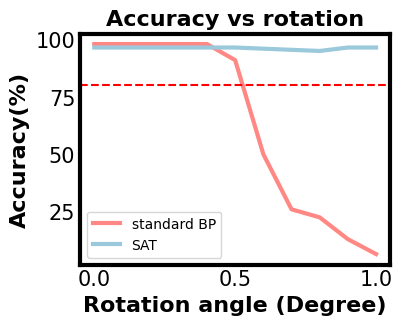

In [41]:
fig, ax = plt.subplots(figsize=(4,3))

plt.plot(sweep_pixel, total_accu_wo*100, linewidth=3, color='#FF8884')
plt.plot(sweep_pixel, total_accu_w*100, linewidth=3, color='#9AC9DB')
# plt.plot(nl_sam, n_pred_sam, linewidth=3, color='#D77076')

plt.xlabel('Rotation angle (Degree)', fontdict={'fontsize': 16, 'fontweight': 'bold'})
plt.ylabel('Accuracy(%)', fontdict={'fontsize': 16, 'fontweight': 'bold'})
plt.title('Accuracy vs rotation', fontdict={'fontsize': 16, 'fontweight': 'bold'})
plt.axhline(y=80, color='r', linestyle='--')
# plt.rcParams["figure.figsize"] = (6, 2)
plt.legend(['standard BP','SAT'], ncol=1)
for spine in ax.spines.values():
    spine.set_linewidth(3)

plt.xticks(np.arange(np.min(sweep_pixel), np.max(sweep_pixel)+0.2, 0.5))
# plt.xlim(0,1)
ax.tick_params(axis='both', which='both', length=0)
ax.tick_params(axis='both', labelsize=15)
plt.show()